# Atari
ALE/SpaceInvaders-v5

## Import Libraries

In [12]:
#https://gymnasium.farama.org/environments/atari/
#pip install gymnasium[atari]
#pip install gymnasium[accept-rom-license]
#pip install moviepy
#https://www.youtube.com/watch?v=hCeJeq8U0lo&t=447s
import datetime

#test environments
import gymnasium as gym

#image preprocessing
from PIL import Image
from gymnasium.core import ObservationWrapper
from gymnasium.spaces.box import Box
import numpy as np
import matplotlib.pyplot as plt

#n-step experience replay
from collections import namedtuple, deque

#deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from gymnasium.wrappers import RecordVideo #enviornment monitoring
import random

from sklearn.model_selection import train_test_split #for splitting memory into training and testing
import pandas as pd

import shap
import math
import datetime

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

In [13]:
meter = {
  "episodes": 0,
  'steps': 0,
  "steps_from_history": 0,
  "steps_to_replay": 0,
  "steps_from_replay": 0,
  "samples_to_xai": 0,
  "samples_to_cnn": 0
}

## Deep Convelutional Q-Learning Agent

In [14]:
### Convelutional Neural Network
class CNN(nn.Module):
    def __init__(self, number_actions):
        super(CNN, self).__init__() # call nn module init
        #define what each layer in CNN is
        self.convolution1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)

        #pass image through convolution layers and get neurons in a flatten layer to pass into a neural network
        self.fc1 = nn.Linear(in_features=self.count_neurons((1, 80, 80)), out_features=40) #1 is number of channels so black and white images, 80 80 is width and height
        self.fc2 = nn.Linear(in_features=40, out_features=number_actions)

    def count_neurons(self, image_dim):#image_dim for example 80px x 80px in size
        """Will give us the number of neurons after convolutions are applied"""
        #we need to first create a fake image (1 batch, 80px x 80px in size), * allows image_dim to be passed as a list
        fake_image = Variable(torch.rand(1, *image_dim))

        #pass image into first layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution1(fake_image), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into second layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into third layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2)) #kernal size is 3, #stride is 2
        
        #now we get all pixels in third layer and flatten it. we get the data, view what's inside it then we get all the pixels and put it into 1 dimension
        return x.data.view(1, -1).size(1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        #propagate data from convolutional layers to hidden layers by first flattening convolutional layers
        #flatten third layer by taking all pixels and all channels in third layer and arrange one after another
        x = x.view(x.size(0), -1) #RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x49 and 3136x40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Softmax Policy
class SoftmaxPolicy(nn.Module):
    """data from the CNN is passed to softmax to play an action"""
    def __init__(self, T=100):
        super(SoftmaxPolicy, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T, dim=1)
        actions = probs.multinomial(num_samples=number_actions)
        return actions

### Agent (DCQ Learning System )
class DCQ():
    def __init__(self, CNN, SoftmaxPolicy):
        self.cnn = CNN
        self.softmax = SoftmaxPolicy

    def __call__(self, inputs):#comes from NStepProgress -> np.array([state])
        """similar to init function but it allows this AI class 
        instance to be treated like a function, not modifying the initial instance"""
        #receive images from the game by converting image into a numpy array then into a torch tensor, then put a torch tensor into a torch variable with a gradient
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.cnn(input)
        actions = self.softmax(output)
        return actions.data.numpy()

### Experience Replay
#### N-Step
class NStepProgress:
    """This class allows the AI to progress on several (n_step) steps"""
    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step
        self.step = namedtuple('Step', ['state', 'action', 'reward', 'done']) #Defining one Step
    def __iter__(self):
        """Repeats iteration only incrementing parent loop when yield is called"""
        state, info = self.env.reset()
        history = deque()
        reward = 0.0
        while True:
            #select an action
            action = self.ai(np.array([state]))[0][0] #agent.update
            meter['steps'] = meter['steps'] + 1
            #get reward and next state
            next_state, r, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated #if  game has some kind of max_steps or timeout, read 'truncated' with 'terminated'
            reward += r
            #add to stacked frame
            history.append(self.step(state=state, action=action, reward=r, done=done))
            
            while len(history) > self.n_step:# + 1: #Always keep it n-steps e.g 10
                history.popleft()

            if len(history) == self.n_step:# + 1:#create our stacked tuple when finished
                meter['steps_from_history'] = meter['steps_from_history'] + len(history)
                self.rewards.append(reward)
                reward = 0.0
                yield tuple(history)
                
            state = next_state
            if done: #either terminated or truncated
                if len(history) > self.n_step:# + 1:
                    history.popleft()
                    
                while len(history) >= 1:
                    meter['steps_from_history'] = meter['steps_from_history'] + len(history)
                    self.rewards.append(reward)
                    reward = 0.0
                    yield tuple(history)
                    history.popleft()
                    
                state, info  = self.env.reset()
                history.clear()
    
    def rewards_steps(self):
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

#### Replay Memory
class ReplayMemory:
    """This class is modified to do n-step learning"""
    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps) #creates an object that can be accessed one element at a time using __next__()
        self.buffer = deque()

    def sample_batch(self, batch_size): # creates an iterator that returns random batches
        ofs = 0 #we use an offset to keep track of starting index for each batch
        #we get samples from experience replay
        vals = list(self.buffer)
        #then randomly suffle them
        np.random.shuffle(vals)
        #now we check to see if we have enough samples in the buffer to make a batch if not we wait.
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size] #we slice from the offset position to the e.g 128 to 256
            ofs += 1
            meter['steps_from_replay'] = meter['steps_from_replay'] +1

    def run_steps(self, steps):
        """Runs environment wait 10 consecutive steps of (state, action, reward, done) then save to buffer
        until n sample steps are saved in buffer. Does not iterate until n_steps_iter collects 10 steps"""

        while steps > 0:
            entry = next(self.n_steps_iter) # 10 consecutive steps of (state, action, reward, done)
            meter['steps_to_replay'] = meter['steps_to_replay'] + len(entry)
            self.buffer.append(entry) # we put e.g 200 for the current episode
            steps -= 1

        while len(self.buffer) > self.capacity: # we accumulate no more than the capacity (10000)
            self.buffer.popleft()
            
### N-Step Q-Learning
def eligibility_trace(batch, cnn, g=0.99):#batch is a sample of 128 10-steps where each step is ['state', 'action', 'reward', 'done'] so 1,280 transitions from memory
    """Asynchronous N-Step Q-Learning
    learns the cumulative rewards and cumulative targets
    on n-steps instead of one step like DQL"""
    gamma = g
    inputs = []
    targets = []
    for series in batch: #series of 10 transitions in our batch
        #get the first and last image as the input. Convert fron numpy to torch variable
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype=np.float32)))
        output = cnn(input) #this is the prediction from the ai

        #if the last transition of the series is not done we get the max q values
        cumulative_reward = 0.0 if series[-1].done else output[1].data.max()

        #start with the last step and go backwards to the first step
        for step in reversed(series[:-1]):#reversed goes backwards 
            state = series[0].state # first state we need. This is where we started
            target = output[0].data # this is the q value of the input state of the first step. This is what we thought we would get being in this state

            # what new reward did we actually get
            cumulative_reward = step.reward + gamma * cumulative_reward 
            target[series[0].action] = cumulative_reward # this is the q value we actually got

            inputs.append(state) # we append our first state
            targets.append(target) #we append the actual target q value for the first state

            #output the input and the target after being processed through eligibility_trace
            #we now have the first state and the target q values for the first state over 10 steps
            return torch.from_numpy(np.array(inputs, dtype=np.float32)), torch.stack(targets)#we stack targets together

### Image Preprocessing
class ImagePreprocessor(ObservationWrapper):
    """Custom Image Preprocessor similar to 
    Atari standard in gymnasium"""
    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(ImagePreprocessor, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        img = Image.fromarray(img)
        img = img.resize(self.img_size)
        if self.grayscale:
            img = img.convert('L')  # Convert to grayscale
        else:
            img = img.convert('RGB')  # Convert to RGB if necessary

        #view preprocessed image
        #plt.imshow(img)
        #plt.show()

        img = np.array(img)
        #adds a new dimension to the array to represent the single color channel, resulting in the desired shape
        img = np.expand_dims(img, axis=2)
        
        #if img.ndim == 2:  # Add channel dimension if missing
        #    img = np.expand_dims(img, axis=2)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255

        #check dim of new image
        #print("image was preprocessed to: " + str("greyscale" if self.grayscale else "RGB") + " with shape " + str(img.shape))
        return img

### Moving Average Reward (for evaluation)
class MA:
    """creates the moving average reward on 
    nth steps to keep track of training performance"""
    def __init__(self, size):
        self.n_step_rewards = []
        self.size = size
        self.cumulative_reward = []

    def add(self, rewards):
        if isinstance(rewards, list):
            self.n_step_rewards += rewards
        else:
            self.n_step_rewards.append(rewards)

        # makes sure that we always have e.g size(200) elements of the latest rewards
        while len(self.n_step_rewards) > self.size:
            del self.n_step_rewards[0]

    def cumulative(self):
        self.cumulative_reward.append(sum(self.n_step_rewards))
        return sum(self.n_step_rewards)

    def calculate_average(self):
        acr = 0.0 
        if len(self.cumulative_reward) > 0:
            acr = np.mean(self.cumulative_reward)
        return acr

## Experiments

### Environment & Experience Replay Capacity Sizes

In [15]:
sim_name = 'ALE/SpaceInvaders-v5' # obs_type="ram", frameskip=4, repeat_action_probability=0.25
# stella emulator for atari = https://stella-emu.github.io/
# https://stella-emu.github.io/docs/index.html#Remapping:~:text=count%20and%20associated-,frames%20per%20second,-%2C%20bankswitch%20and%20display
# assume 60 fps


capacity = [1000000, 500000, 100000, 50000, 10000, 5000, 1000, 500] #capacity = [1000000]
labels = ['1M', '500k', '100k', '50k', '10k', '5k', '1k', '500']

#create table for evaluating capacity against reward
df_rewards = pd.DataFrame(columns=['capacity', 'episodes', 'reward'])

### Simulation

EXPERIMENT 0: Date-Time: 2023-08-12 22:59:52, Capacity: 1k
Setting up environment
Creating Agent with capacity set to: 1000
Simulating environment
Episode: 0, Cumulative Reward: 50.0
END - Date-Time: 2023-08-12 22:59:53
Plotting results


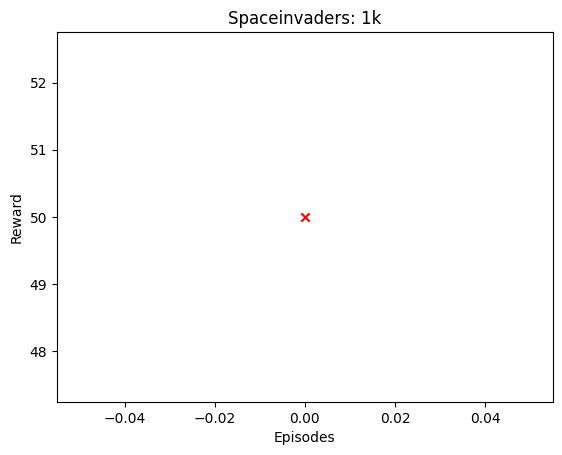

FixedFormatter should only be used together with FixedLocator


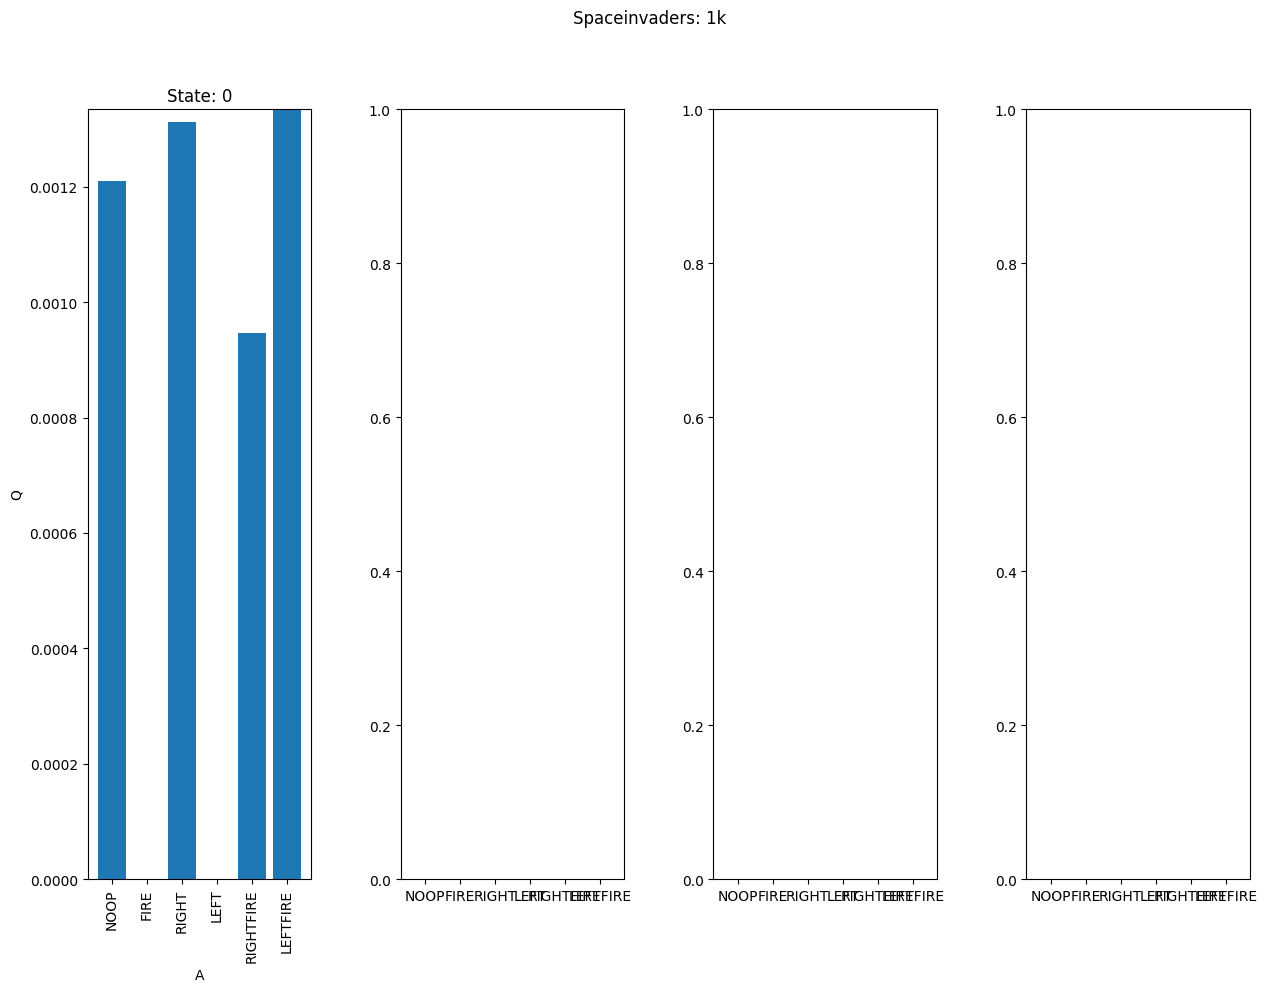

{'episodes': 1, 'steps': 209, 'steps_from_history': 2000, 'steps_to_replay': 2000, 'steps_from_replay': 2, 'samples_to_xai': 1, 'samples_to_cnn': 1}
average cumulative reward: 50.0


In [16]:
for i, cap in enumerate(capacity):
    #get current timestamp
    start_datetime = datetime.datetime.now()
    start_datetime = start_datetime.strftime("%Y-%m-%d %H:%M:%S")# Format the date and time as a string
    print("EXPERIMENT " + str(i) + ": Date-Time: " + str(start_datetime) + ", Capacity: " + str(labels[i]))
    
    #### Setup Preprocessed Environment
    print("Setting up environment")
    #env = gym.make('ALE/SpaceInvaders-v5')
    #We first preprocess the image by applying a greyscale and reducing the size to 80px. 
    env = ImagePreprocessor(gym.make(sim_name), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'
    state, info = env.reset(seed=42)
    episodes = 1 #200
    steps_per_episode = 200 #steps to take
    
    ##### Create DCQL Agent
    print("Creating Agent with capacity set to: " + str(cap))
    a = env.action_space.n # actions
    g = 0.9 #gamma
    c = cap #1000000 #10000 #memory capacity
    b = 100 #training batches
    l = 0.001 #learning rate
    t = 1.0 #softmax policy temperature rate. T is temperature high, meaning other actions are less explored
    n = 10 # n-steps

    #Build the Agent
    cnn = CNN(a)
    softmax = SoftmaxPolicy(T=t) # 
    agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

    # Set up Experience Replay
    n_steps = NStepProgress(env=env, ai=agent, n_step=n) #instead of learning every transition we learn every nth transition
    memory = ReplayMemory(n_steps=n_steps, capacity=c) #store the last c steps in memory e.g 1millm 500k etc.

    #set learning parameters
    loss = nn.MSELoss()#calculate mean squared error loss
    optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

    ma = MA(steps_per_episode) #used to get the average of the last n-step rewards

    #### Simulate the environment
    print("Simulating environment")

    # Initialize an empty list to store the sampled inputs for SHAP Explainer
    # set a sampling rate based on episodes as batches could be zero if not enough available at start

    #define a random selection size such as 10%
    random_select_size = math.ceil(episodes * 0.1) # 10%

    # Create an array of random episode numbers
    random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

    # Initialize an empty list to store the sampled inputs for SHAP Explainer
    sampling_episode = []
    sampled_inputs = []
    sampled_targets = []
    episode_sampled = False  # Initialize the flag

    for episode in range(episodes):
        #run the game for 200 runs of 10 steps and push sample transitions into memory
        memory.run_steps(steps=steps_per_episode) # e.g 200 steps
        #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
        for batch in memory.sample_batch(b): #b= e.g 128 batches
            #agent training

            #creates the training set for the agent, 
            # we get target discounted q values for the first state in the batch over 10 steps
            inputs, targets = eligibility_trace(batch, cnn, g)

            #We take some training samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
            if episode in random_episodes and not episode_sampled:
                sampling_episode.append(episode) #record when sample was taken
                sampled_inputs.append(inputs)
                sampled_targets.append(targets)
                meter["samples_to_xai"] = meter["samples_to_xai"] + 1
                episode_sampled = True # Set the flag to True
            else:
                #we convert them to tensor variables
                inputs, targets = Variable(inputs), Variable(targets)

                #like during eligibility_trace we get predicted q values from the cnn model
                predictions = cnn(inputs)
                loss_error = loss(predictions, targets)
                optimizer.zero_grad()
                loss_error.backward()
                optimizer.step()
                meter["samples_to_cnn"] = meter["samples_to_cnn"] + 1
        
        episode_sampled = False # Reset the flag for the next iteration
                
        rewards_steps = n_steps.rewards_steps() #e.g get 200 steps with rewards
        ma.add(rewards_steps) #e.g add those 200 steps with rewards
        cumulative_reward = ma.cumulative()
        print("Episode: %s, Cumulative Reward: %s" % (str(episode), str(round(cumulative_reward,2))))
        meter["episodes"] = meter["episodes"] + 1
    env.close()

    #get end timestamp
    end_datetime = datetime.datetime.now()
    end_datetime = end_datetime.strftime("%Y-%m-%d %H:%M:%S")# Format the date and time as a string
    print("END - Date-Time: " + str(end_datetime))

    #### HOW did the agent performed?
    print("Plotting results")

    ##### Agent's final score
    #optimal_index = np.argmax(ma.average_rewards)  # Find the index of the highest cumulative reward
    #episode_index = np.arange(0, episodes-1)
    #optimal_episode = episode_index[optimal_index]  # Get the corresponding episode number

    ##### Rewards at given time/step
    # Iterate over the rows of cumulative_reward and append them to df_rewards
    for episode, reward in enumerate(ma.cumulative_reward):
        new_row = [labels[i], episode, reward]
        df_rewards.loc[len(df_rewards)] = new_row
        
    # Save and plot reward
    title = sim_name[4:-3]
    plt.title(title.capitalize() + ": " + str(labels[i]))
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.plot(ma.cumulative_reward)

    # Draw a vertical line at the optimal point
    #plt.axvline(x=optimal_episode, color='r', linestyle='--', label='Optimal Point')

    # Draw red dots at the sampled experiences
    plt.scatter(sampling_episode, [ma.cumulative_reward[exp] for exp in sampling_episode],
                marker='x', color='r', label='Experience Sampled', zorder=5)

    filename = sim_name.replace("/", "_")
    plt.savefig("./../plots/rewardplots/" + filename +"_"+ str(labels[i]) + ".png")
    plt.show()


    #save and plot q-values from sampled experience
    num_columns = 4  # Number of columns in the grid
    num_rows = (len(sampled_targets) + num_columns - 1) // num_columns  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 10), sharex=True)

    # Adjust spacing between cells
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust these values as needed

    max_q_value = np.max([np.max(np.array(sampled_targets[s])[0]) for s in range(len(sampled_targets))])

    # Iterate through sampled_targets
    for s, ax in enumerate(axs.flat):
        if s < len(sampled_targets):
            # Set the x-axis values
            x = env.unwrapped.get_action_meanings()

            # Set the y-axis values and divide by 100
            y = np.array(sampled_targets[s])[0] / 100

            # Create the bar chart
            ax.bar(x, y)

            # Set the labels and title
            ax.set_xlabel('A')
            ax.set_ylabel('Q')
            ax.set_title('State: ' + str(sampling_episode[s]))  # Use 's' as title

            # Rotate the x-axis labels if needed
            ax.set_xticklabels(x, rotation=90)

            # Set y-axis scale to max of largest Q-value
            ax.set_ylim(0, max_q_value / 100)

    # Add an overall title to the grid
    fig.suptitle(title.capitalize() + ": " + str(labels[i]))

    plt.savefig("./../plots/qvalueplots/" + filename +"_"+ str(labels[i]) + ".png")
    # Display the grid of bar charts
    plt.show()
    
    print(meter)
    print("average cumulative reward: " + str(ma.calculate_average()))
    #print("episode until found: " + str(optimal_episode))

    #### Save Trained Model
    #torch.save(cnn, './../models/space_invaders.pth')
    #### Load Trained Model
    #cnn = torch.load('./../models/space_invaders.pth')
    #cnn.eval()

In [17]:
print(meter)

{'episodes': 1, 'steps': 209, 'steps_from_history': 2000, 'steps_to_replay': 2000, 'steps_from_replay': 2, 'samples_to_xai': 1, 'samples_to_cnn': 1}


#### WHY does the agent take an actions in the given state?

In [18]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[0]


1

In [19]:
x = sampling_episode
print(x)

[0]


In [20]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

1


In [22]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[0]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3098, 0.3098, 0.3098,  ..., 0.3098, 0.3098, 0.3098],
          [0.3098, 0.3098, 0.3098,  ..., 0.3098, 0.3098, 0.3098],
          [0.3098, 0.3098, 0.3098,  ..., 0.3098, 0.3098, 0.3098]]]])

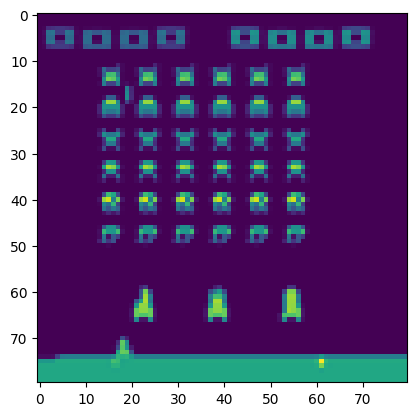

In [24]:
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    if i < len(sampled_inputs):
        # Assuming sampled_inputs[i] is a numpy array or tensor
        image = sampled_inputs[i].view(80, 80, 1).numpy()  # Convert to numpy array if needed
        ax.imshow(image.squeeze(), cmap='gray')  # 'gray' colormap for grayscale images
        ax.axis('off')  # Turn off axis labels
    else:
        ax.axis('off')  # If there are fewer than 20 images, turn off the empty subplots

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [ ]:
# we see what Q values were calculated for each action for first image
sampled_targets[0]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[ 387.4649,  407.2264,  979.4785,   -2.9645, 1676.5990,   61.5365]])

## ANOVA

In [ ]:
df_rewards.tail()

,capacity,episodes,reward
192,1k,192,260.479452
193,1k,193,260.479452
194,1k,194,260.608108
195,1k,195,260.608108
196,1k,196,260.608108


In [ ]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_atari_space_invaders_shap" + ".csv"
df_rewards.to_csv(file_name, index=False, encoding='utf-8')

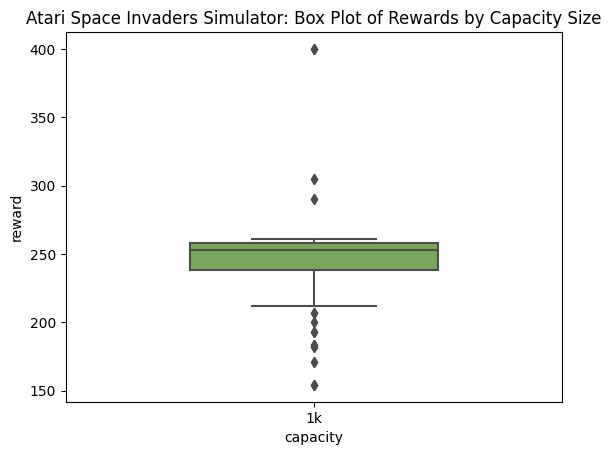

In [ ]:
ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, color='#77B150', width=0.5).set(title='Atari Space Invaders Simulator: Box Plot of Rewards by Capacity Size')
plt.show()